### Load Package

In [1]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from dateutil.parser import parse
from datetime import date, timedelta
pd.options.mode.chained_assignment = None # hide warning Try using .loc[row_indexer,col_indexer] = value instead

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
# https://medium.com/analytics-vidhya/recruit-restaurant-visitor-forecasting-f9ef87ba1073

In [2]:
%matplotlib inline

### Load Data

In [4]:
data_path = 'data/'

air_reserve = pd.read_csv(data_path + 'air_reserve.csv').rename(columns={'air_store_id':'store_id'})
hpg_reserve = pd.read_csv(data_path + 'hpg_reserve.csv').rename(columns={'hpg_store_id':'store_id'})
air_store = pd.read_csv(data_path + 'air_store_info.csv').rename(columns={'air_store_id':'store_id'})
hpg_store = pd.read_csv(data_path + 'hpg_store_info.csv').rename(columns={'hpg_store_id':'store_id'})
air_visit = pd.read_csv(data_path + 'air_visit_data.csv').rename(columns={'air_store_id':'store_id'})
store_id_map = pd.read_csv(data_path + 'store_id_relation.csv').set_index('hpg_store_id',drop=False)
date_info = pd.read_csv(data_path + 'date_info.csv').rename(columns={'calendar_date': 'visit_date'}).drop('day_of_week',axis=1)
submission = pd.read_csv(data_path + 'sample_submission.csv')
weather = pd.read_csv('data_additional/' + 'weather_ready_to_use.csv')

### EDA

ref from [mariuszrokita](https://github.com/mariuszrokita/kaggle-recruit-restaurant-visitor-forecasting/tree/master/notebooks)

#### Null Value Analysis

In [5]:
air_reserve.isnull().sum()

store_id            0
visit_datetime      0
reserve_datetime    0
reserve_visitors    0
dtype: int64

In [6]:
hpg_reserve.isnull().sum()

store_id            0
visit_datetime      0
reserve_datetime    0
reserve_visitors    0
dtype: int64

In [7]:
air_store.isnull().sum()

store_id          0
air_genre_name    0
air_area_name     0
latitude          0
longitude         0
dtype: int64

In [8]:
hpg_store.isnull().sum()

store_id          0
hpg_genre_name    0
hpg_area_name     0
latitude          0
longitude         0
dtype: int64

In [9]:
air_visit.isnull().sum()

store_id      0
visit_date    0
visitors      0
dtype: int64

In [10]:
store_id_map.isnull().sum()

air_store_id    0
hpg_store_id    0
dtype: int64

In [11]:
date_info.isnull().sum()

visit_date     0
holiday_flg    0
dtype: int64

In [12]:
weather.isnull().sum()

store_id                   0
visit_date                 0
precipitation         134080
low_temperature        43432
avg_temperature        43428
high_temperature       43432
hours_sunlight         61645
solar_radiation       141141
avg_wind_speed         43621
avg_vapor_pressure    112684
avg_local_pressure    112189
avg_humidity          112684
avg_sea_pressure      112189
cloud_cover           128216
dtype: int64

#### submission 

In [96]:
submission['visit_date'] = pd.to_datetime(submission['id'].str[-10:])
submission.head(20)

,id,visitors,visit_date
0,air_00a91d42b08b08d9_2017-04-23,0,2017-04-23
1,air_00a91d42b08b08d9_2017-04-24,0,2017-04-24
2,air_00a91d42b08b08d9_2017-04-25,0,2017-04-25
3,air_00a91d42b08b08d9_2017-04-26,0,2017-04-26
4,air_00a91d42b08b08d9_2017-04-27,0,2017-04-27
5,air_00a91d42b08b08d9_2017-04-28,0,2017-04-28
6,air_00a91d42b08b08d9_2017-04-29,0,2017-04-29
7,air_00a91d42b08b08d9_2017-04-30,0,2017-04-30
8,air_00a91d42b08b08d9_2017-05-01,0,2017-05-01
9,air_00a91d42b08b08d9_2017-05-02,0,2017-05-02


In [98]:
print ('min visit date {}'.format(np.min(submission.visit_date)))
print ('max visit date {}'.format(np.max(submission.visit_date)))

min visit date 2017-04-23 00:00:00
max visit date 2017-05-31 00:00:00


#### date_info

In [99]:
date_info['visit_date'] = pd.to_datetime(date_info['visit_date'])
date_info.head(20)

,visit_date,holiday_flg
0,2016-01-01,1
1,2016-01-02,1
2,2016-01-03,1
3,2016-01-04,0
4,2016-01-05,0
5,2016-01-06,0
6,2016-01-07,0
7,2016-01-08,0
8,2016-01-09,0
9,2016-01-10,0


In [100]:
print ('min visit date {}'.format(np.min(date_info.visit_date)))
print ('max visit date {}'.format(np.max(date_info.visit_date)))

min visit date 2016-01-01 00:00:00
max visit date 2017-05-31 00:00:00


#### air_reserve

In [34]:
air_reserve['reserve_datetime'] = pd.to_datetime(air_reserve['reserve_datetime'])
air_reserve['visit_datetime'] = pd.to_datetime(air_reserve['visit_datetime'])
air_reserve['reserve_datetime_weekdayname'] = air_reserve['reserve_datetime'].dt.day_name()
air_reserve['visit_datetime_weekdayname'] = air_reserve['visit_datetime'].dt.day_name()

<Figure size 576x288 with 0 Axes>

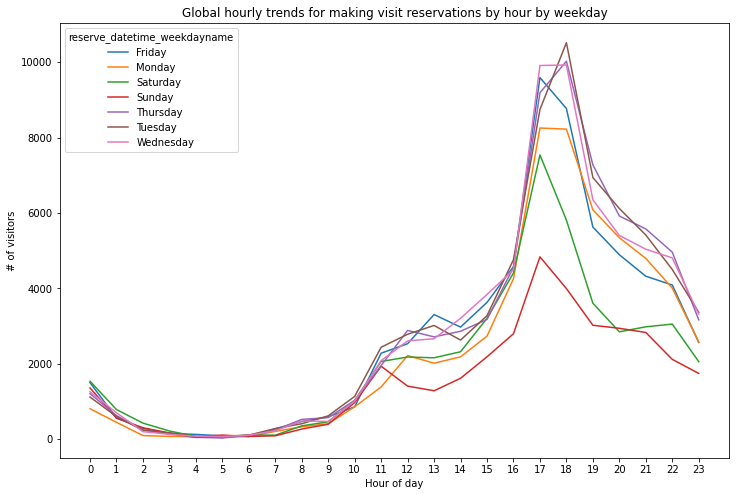

In [35]:
plt.figure(figsize=(8, 4))
ax = air_reserve.pivot_table(index=air_reserve['reserve_datetime'].dt.hour, 
                    columns='reserve_datetime_weekdayname', 
                    values='reserve_visitors', 
                    aggfunc='sum').plot(figsize=(12,8), 
                                        title='Global hourly trends for making visit reservations by hour by weekday',
                                        xticks=np.arange(0, 24, 1))
 
ax.set_xlabel("Hour of day")
ax.set_ylabel("# of visitors")
plt.show();

<Figure size 576x288 with 0 Axes>

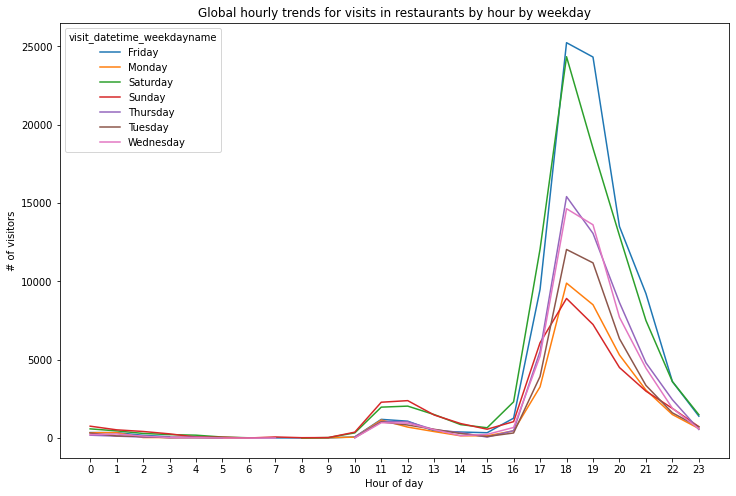

In [36]:
plt.figure(figsize=(8, 4))
ax = air_reserve.pivot_table(index=air_reserve['visit_datetime'].dt.hour, 
                    columns='visit_datetime_weekdayname', 
                    values='reserve_visitors', 
                    aggfunc='sum').plot(figsize=(12,8), 
                                        title='Global hourly trends for visits in restaurants by hour by weekday',
                                        xticks=np.arange(0, 24, 1))

ax.set_xlabel("Hour of day")
ax.set_ylabel("# of visitors");
plt.show();

<Figure size 576x288 with 0 Axes>

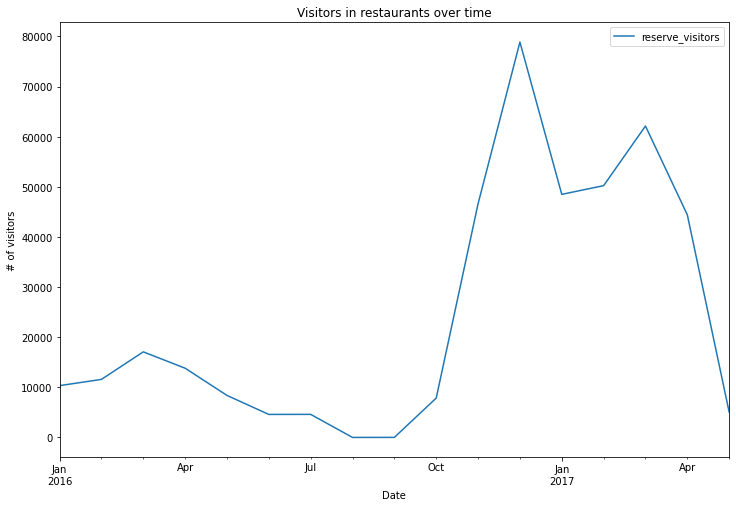

In [42]:
plt.figure(figsize=(8, 4))

ax = (air_reserve[['visit_datetime', 'reserve_visitors']].set_index('visit_datetime')).resample('M').sum()\
        .plot(figsize=(12,8), title='Visitors in restaurants over time');
ax.set_xlabel("Date")
ax.set_ylabel("# of visitors")
plt.show();

#### air_store

In [43]:
air_store['air_genre_name'].value_counts()

Izakaya                         197
Cafe/Sweets                     181
Dining bar                      108
Italian/French                  102
Bar/Cocktail                     79
Japanese food                    63
Other                            27
Yakiniku/Korean food             23
Western food                     16
Okonomiyaki/Monja/Teppanyaki     14
Creative cuisine                 13
Asian                             2
International cuisine             2
Karaoke/Party                     2
Name: air_genre_name, dtype: int64

In [44]:
air_store['air_genre_name'].value_counts()

Izakaya                         197
Cafe/Sweets                     181
Dining bar                      108
Italian/French                  102
Bar/Cocktail                     79
Japanese food                    63
Other                            27
Yakiniku/Korean food             23
Western food                     16
Okonomiyaki/Monja/Teppanyaki     14
Creative cuisine                 13
Asian                             2
International cuisine             2
Karaoke/Party                     2
Name: air_genre_name, dtype: int64

In [45]:
air_store['air_area_name'].value_counts()

Fukuoka-ken Fukuoka-shi Daimyō          64
Tōkyō-to Shibuya-ku Shibuya             58
Tōkyō-to Minato-ku Shibakōen            51
Tōkyō-to Shinjuku-ku Kabukichō          39
Tōkyō-to Setagaya-ku Setagaya           30
                                        ..
Tōkyō-to Taitō-ku Kuramae                2
Hokkaidō Sapporo-shi Kita 24 Jōnishi     2
Niigata-ken Kashiwazaki-shi Chūōchō      2
Tōkyō-to Shibuya-ku Dōgenzaka            2
Fukuoka-ken Fukuoka-shi Tenjin           2
Name: air_area_name, Length: 103, dtype: int64

In [46]:
air_store['air_area_name_prefecture'] = air_store['air_area_name'].str.split('\s+').str[0]
air_store['air_area_name_ward'] = air_store['air_area_name'].str.split('\s+').str[1]
air_store['air_area_name_area'] = air_store['air_area_name'].str.split('\s+').str[2]

In [48]:
air_store.head()

,store_id,air_genre_name,air_area_name,latitude,longitude,air_area_name_prefecture,air_area_name_ward,air_area_name_area
0,air_0f0cdeee6c9bf3d7,Italian/French,Hyōgo-ken Kōbe-shi Kumoidōri,34.695124,135.197852,Hyōgo-ken,Kōbe-shi,Kumoidōri
1,air_7cc17a324ae5c7dc,Italian/French,Hyōgo-ken Kōbe-shi Kumoidōri,34.695124,135.197852,Hyōgo-ken,Kōbe-shi,Kumoidōri
2,air_fee8dcf4d619598e,Italian/French,Hyōgo-ken Kōbe-shi Kumoidōri,34.695124,135.197852,Hyōgo-ken,Kōbe-shi,Kumoidōri
3,air_a17f0778617c76e2,Italian/French,Hyōgo-ken Kōbe-shi Kumoidōri,34.695124,135.197852,Hyōgo-ken,Kōbe-shi,Kumoidōri
4,air_83db5aff8f50478e,Italian/French,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,Tōkyō-to,Minato-ku,Shibakōen


In [47]:
air_store['air_area_name_prefecture'].value_counts()

Tōkyō-to         444
Fukuoka-ken      127
Ōsaka-fu          74
Hyōgo-ken         57
Hokkaidō          46
Hiroshima-ken     32
Shizuoka-ken      18
Miyagi-ken        17
Niigata-ken       14
Name: air_area_name_prefecture, dtype: int64

In [49]:
air_store['air_area_name_area'].value_counts()

Daimyō       64
Shibuya      58
Shibakōen    51
Kabukichō    39
Setagaya     30
             ..
Honchō        2
Sendagi       2
Jingūmae      2
Higashi       2
Nakanochō     2
Name: air_area_name_area, Length: 99, dtype: int64

#### air_visit

In [54]:
df = air_visit[['visit_date', 'visitors']].set_index("visit_date")
df.index = pd.to_datetime(df.index)

<Figure size 576x288 with 0 Axes>

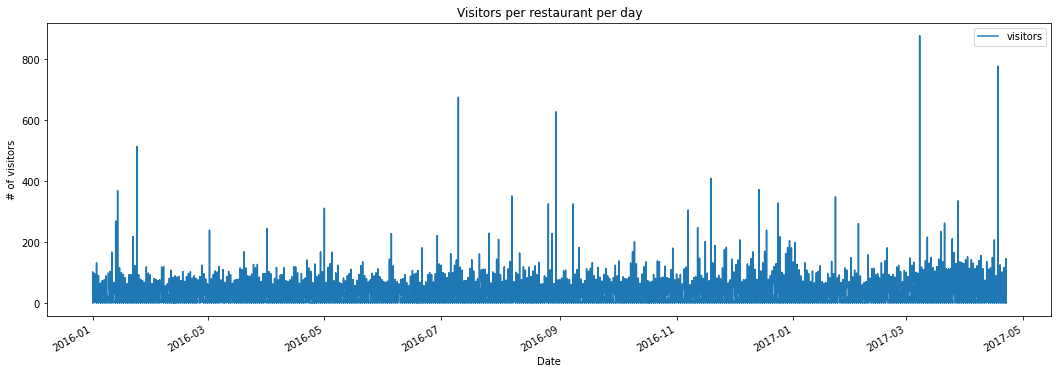

In [55]:
plt.figure(figsize=(8, 4))
ax = df.plot(figsize=(18,6), title='Visitors per restaurant per day');
ax.set_xlabel("Date")
ax.set_ylabel("# of visitors")
plt.show();

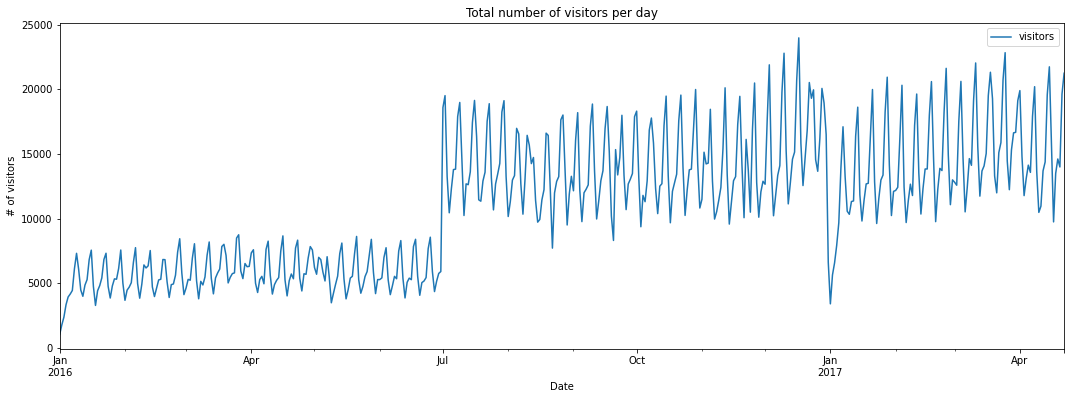

In [58]:
ax = df.resample('D').sum().plot(figsize=(18,6), title='Total number of visitors per day');
ax.set_xlabel("Date")
ax.set_ylabel("# of visitors");

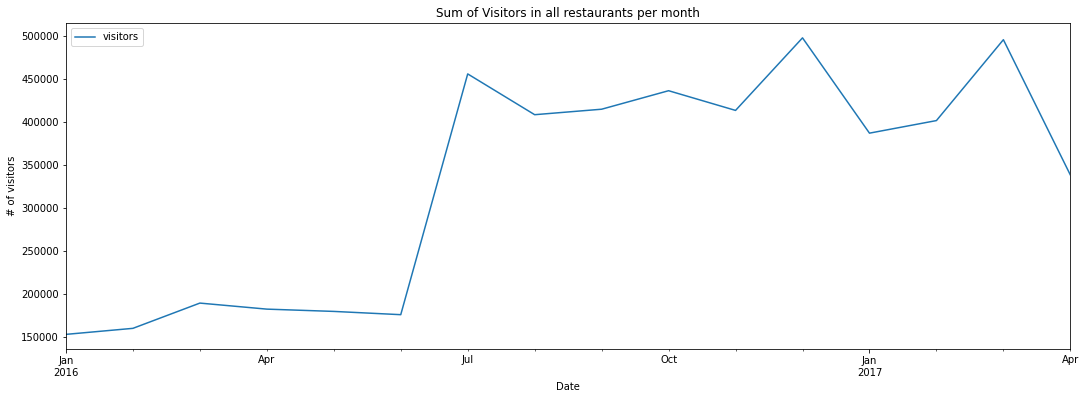

In [59]:
ax = df.resample('M').sum().plot(figsize=(18,6), 
                                   title='Sum of Visitors in all restaurants per month');
ax.set_xlabel("Date")
ax.set_ylabel("# of visitors");

In [70]:
air_visit.groupby('store_id')['visitors'] \
    .agg(overall_number_of_visitors= "sum") \
    .sort_values(by="overall_number_of_visitors", ascending=False)

,overall_number_of_visitors
store_id,
air_399904bdb7685ca0,18717
air_f26f36ec4dc5adb0,18577
air_e55abd740f93ecc4,18101
air_99157b6163835eec,18097
air_5c817ef28f236bdf,18009
...,...
air_9dd7d38b0f1760c4,803
air_5b704df317ed1962,800
air_fdcfef8bd859f650,625


#### hpg_reserve

In [73]:
print('The dataset contains info about {} restaurants'.format(len(hpg_reserve['store_id'].unique())))

The dataset contains info about 13325 restaurants


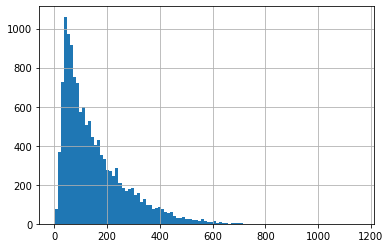

In [75]:
plt.figure()
hpg_reserve['store_id'].value_counts().hist(bins=100)
plt.show();

In [79]:
hpg_reserve['reserve_datetime'] = pd.to_datetime(hpg_reserve['reserve_datetime'])
hpg_reserve['visit_datetime'] = pd.to_datetime(hpg_reserve['visit_datetime'])
hpg_reserve['reserve_datetime_weekdayname'] = hpg_reserve['reserve_datetime'].dt.day_name()
hpg_reserve['visit_datetime_weekdayname'] = hpg_reserve['visit_datetime'].dt.day_name()

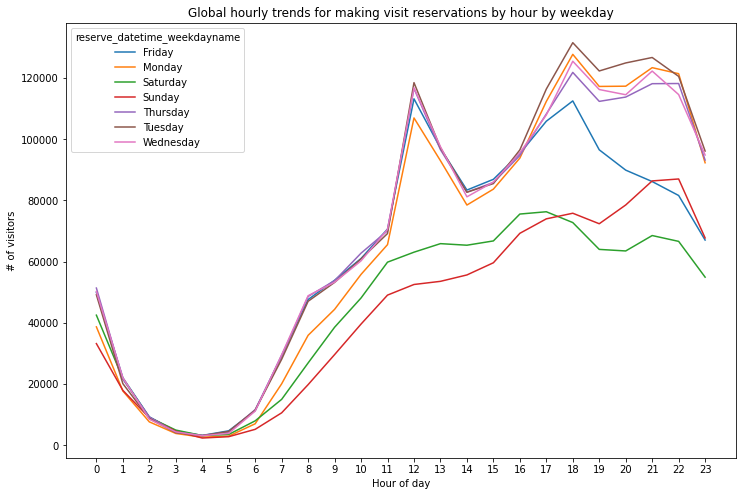

In [80]:
ax = hpg_reserve.pivot_table(index=hpg_reserve['reserve_datetime'].dt.hour, 
                    columns='reserve_datetime_weekdayname', 
                    values='reserve_visitors', 
                    aggfunc='sum').plot(figsize=(12,8), 
                                        title='Global hourly trends for making visit reservations by hour by weekday',
                                        xticks=np.arange(0, 24, 1))
 
ax.set_xlabel("Hour of day")
ax.set_ylabel("# of visitors");

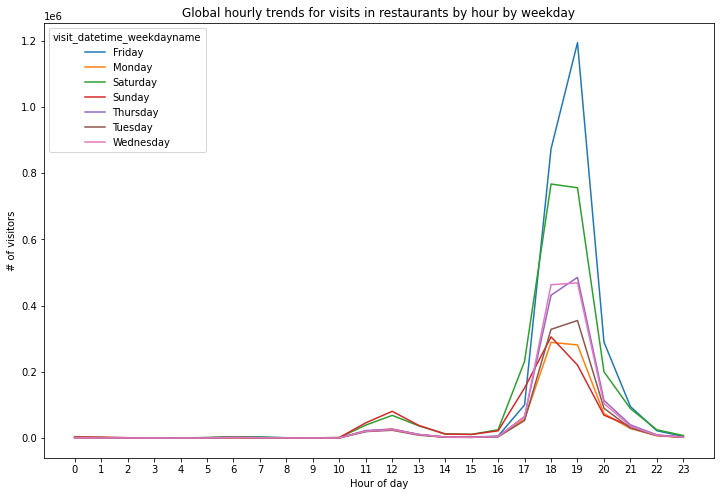

In [81]:
ax = hpg_reserve.pivot_table(index=hpg_reserve['visit_datetime'].dt.hour, 
                    columns='visit_datetime_weekdayname', 
                    values='reserve_visitors', 
                    aggfunc='sum').plot(figsize=(12,8), 
                                        title='Global hourly trends for visits in restaurants by hour by weekday',
                                        xticks=np.arange(0, 24, 1))

ax.set_xlabel("Hour of day")
ax.set_ylabel("# of visitors");

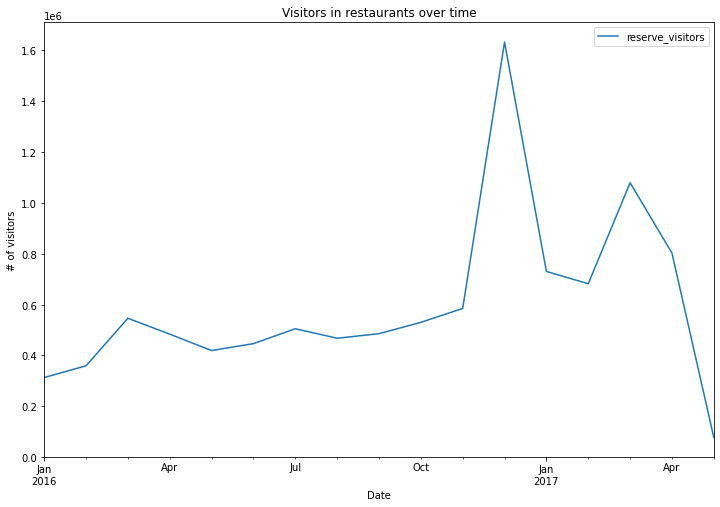

In [82]:
ax = hpg_reserve[['visit_datetime','reserve_visitors']].set_index('visit_datetime').resample('M').sum()\
        .plot(figsize=(12,8), title='Visitors in restaurants over time');
ax.set_xlabel("Date")
ax.set_ylabel("# of visitors");

#### hpg_store

In [84]:
hpg_store['hpg_genre_name'].value_counts()

Japanese style                  1750
International cuisine            700
Creation                         410
Seafood                          339
Grilled meat                     325
Italian                          249
Spain Bar/Italian Bar            229
Chinese general                   91
Japanese food in general          85
Japanese cuisine/Kaiseki          64
Karaoke                           60
Creative Japanese food            60
Shabu-shabu/Sukiyaki              59
Okonomiyaki/Monja/Teppanyaki      44
Party                             40
Korean cuisine                    38
French                            27
Steak/Hamburger/Curry             24
Bistro                            22
Cafe                              16
Sushi                             11
Pasta/Pizza                       10
Bar/Cocktail                       7
Western food                       5
Thai/Vietnamese food               5
Amusement bar                      5
Cantonese food                     4
S

In [85]:
hpg_store['hpg_area_name'].value_counts()

Tōkyō-to Shinjuku-ku None              257
Tōkyō-to Chūō-ku Ginza                 198
Hyōgo-ken Kōbe-shi None                163
Ōsaka-fu Ōsaka-shi Shinsaibashisuji    150
Osaka Prefecture Osaka None            145
                                      ... 
Fukuoka-ken Iizuka-shi Mashiki           2
Hokkaidō Ashibetsu-shi None              1
Tōkyō-to Shinagawa-ku Koyama             1
Ōsaka-fu Minoo-shi Hanjo                 1
Niigata-ken Nagaoka-shi Rokusho          1
Name: hpg_area_name, Length: 119, dtype: int64

In [86]:
hpg_store['hpg_area_name_prefecture'] = hpg_store['hpg_area_name'].str.split('\s+').str[0]
hpg_store['hpg_area_name_ward'] = hpg_store['hpg_area_name'].str.split('\s+').str[1]
hpg_store['hpg_area_name_area'] = hpg_store['hpg_area_name'].str.split('\s+').str[2]

In [87]:
hpg_store['hpg_area_name_prefecture'].value_counts()

Tōkyō-to         2076
Ōsaka-fu          514
Fukuoka-ken       380
Hyōgo-ken         331
Hokkaidō          298
Hiroshima-ken     245
Shizuoka-ken      231
Osaka             145
Niigata-ken       142
Miyagi-ken        139
None              117
Kanagawa-ken       61
Saitama-ken        11
Name: hpg_area_name_prefecture, dtype: int64

#### store_id_map

In [101]:
store_id_map.head()

,air_store_id,hpg_store_id
hpg_store_id,,
hpg_4bc649e72e2a239a,air_63b13c56b7201bd9,hpg_4bc649e72e2a239a
hpg_c34b496d0305a809,air_a24bf50c3e90d583,hpg_c34b496d0305a809
hpg_cd8ae0d9bbd58ff9,air_c7f78b4f3cba33ff,hpg_cd8ae0d9bbd58ff9
hpg_de24ea49dc25d6b8,air_947eb2cae4f3e8f2,hpg_de24ea49dc25d6b8
hpg_653238a84804d8e7,air_965b2e0cf4119003,hpg_653238a84804d8e7


#### Merge Data

https://github.com/mariuszrokita/kaggle-recruit-restaurant-visitor-forecasting/blob/master/notebooks/1.1-initial-data-exploration_all_files.ipynb